In [1]:
import pandas as pd
import os
import bs4
import pickle
import requests
from bs4 import BeautifulSoup
import sys
import matplotlib.pyplot as plt
from scipy.stats import linregress
import numpy as np

In [7]:
company_list = ["Merck"]
years = ['2018', "2017"]
filing_type = '10-K'

In [11]:
#DO NOT NEED TO RUN: CSV Already Created
#Found at https://pythonprogramming.net/sp500-company-list-python-programming-for-finance/
#I added more lists to obtain the Company name and CIK numbers, then combined into a DataFrame and Exported it out

resp = requests.get('http://en.wikipedia.org/wiki/List_of_S%26P_500_companies')
soup = bs4.BeautifulSoup(resp.text, 'lxml')
table = soup.find('table', {'class': 'wikitable sortable'})

key_path = os.path.join('..','Financials', 'Ticker_and_CIK', 'Key.csv')

stock_tickers = []
companies = []
central_index_keys = []

for sp_row in table.findAll('tr')[1:]:
    stock_ticker = sp_row.findAll('td')[0].text
    stock_tickers.append(stock_ticker.rstrip())
    company = sp_row.findAll('td')[1].text
    companies.append(company.rstrip())
    central_index_key = sp_row.findAll('td')[7].text
    central_index_keys.append(central_index_key.rstrip())

sp500_df = pd.DataFrame(list(zip(stock_tickers, companies, central_index_keys)), columns = ["Ticker", "Company", "CIK"])
sp500_df.to_csv(key_path, index = False)

In [8]:
key_path = os.path.join('..','Financials', 'Ticker_and_CIK', 'Key.csv')

key_df = pd.read_csv(key_path)

key_dict = {}

for query in range(len(company_list)):
    try:
        company_df = key_df[key_df['Company'].str.contains(company_list[query].title())]
        key_dict[company_df.iloc[0, 1]] = [company_df.iloc[0, 0], company_df.iloc[0, 2]]
    except IndexError:
        print(f"{company_list[query]} could not be found")

if key_dict == {}:
    print ("Whoops, none of your companies were on the S&P 500. Please try again!")
else:
    print (f"Success! We were able to find {len(key_dict.keys())} of your queries in the S&P 500")
    print (f"We found: {list(key_dict.keys())} in the S&P 500")
    print (key_dict)

Success! We were able to find 1 of your queries in the S&P 500
We found: ['Merck & Co.'] in the S&P 500
{'Merck & Co.': ['MRK', 310158]}


In [9]:
#Unmodified Base Code found at https://www.codeproject.com/Articles/1227765/Parsing-XBRL-with-Python
#I added the ability for the code to query through a list of companies for multiple years and multiple quarters
#and save the statements 

date_dict = {}

for companies_found in range(len(key_dict.keys())):
    
    company_name = list(key_dict.keys())[companies_found]
    ticker = key_dict.get(company_name)[0]
    
    cik = key_dict.get(company_name)[1]
    dateb = f'{years[0]}-12-31'
    
    # Obtain HTML for search page
    base_url = "https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK={}&type={}&dateb={}"
    edgar_resp = requests.get(base_url.format(cik, filing_type, dateb))
    edgar_str = edgar_resp.text
    
    doc_links = []
    dates = []
    
            
    # Find the document link
    soup = BeautifulSoup(edgar_str, 'html.parser')
    table_tag = soup.find('table', class_='tableFile2')
    rows = table_tag.find_all('tr')
        
    for year in years:
        for row in rows:
            cells = row.find_all('td')
            if len(cells) > 3:
                if year in cells[3].text:
                    doc_link = 'https://www.sec.gov' + cells[1].a['href']
                    date = cells[3].text
                    dates.append(date)
                    
                    # Obtain HTML for document page
                    doc_resp = requests.get(doc_link)
                    doc_str = doc_resp.text
                    # Find the XBRL link
                    xbrl_link = ''
                    soup_doc = BeautifulSoup(doc_str, 'html.parser')
                    table_tag_doc = soup_doc.find('table', class_='tableFile', summary='Data Files')
                    rows_doc = table_tag_doc.find_all('tr')
                    for row_doc in rows_doc:
                        cells_doc = row_doc.find_all('td')
                        if len(cells_doc) > 3:
                            if 'INS' in cells_doc[3].text:
                                xbrl_link = 'https://www.sec.gov' + cells_doc[2].a['href']
                    # Obtain XBRL text from document
                    xbrl_resp = requests.get(xbrl_link)
                    xbrl_str = xbrl_resp.text
                    # Find and print stockholder's equity
                    soup_xbrl = BeautifulSoup(xbrl_str, 'lxml')
                    tag_list = soup_xbrl.find_all()

                    df = pd.DataFrame()

                    for tag in tag_list:

                        #Modified from the original; The original searched through to find specific line items
                        #Modified to search through every 10-Q per given year, and extract any financial line item into its own 10-Q

                        if tag.name.find('us-gaap:') != -1:
                            try: 
                                if float(tag.text) > 0:
                                    i = [f'{tag.name}', tag.text, tag['contextref']]
                                    i_series = pd.Series(i)
                                    df = df.append(i_series, ignore_index = True)
                            except ValueError:
                                pass

                    folder_path = os.path.join('..','Financials',f'{filing_type}s',f'{ticker}')
                    file_path = os.path.join('..','Financials',f'{filing_type}s',f'{ticker}', f'{ticker}_{date}.csv')

                    try:
                        os.mkdir(folder_path)
                    except FileExistsError:
                        pass
                    df.to_csv(file_path, index = False)
                    
    date_dict[ticker]=dates
    
date_dict

{'MRK': ['2018-02-27', '2017-02-28']}

In [121]:
curr_ratio_dict = {}
per_change_dict = {}
bvps_dict = {}
eps_dict = {}
week_change_dict = {}
month_change_dict = {}
stock_price_dict = {}

for companies_found in range(len(date_dict.keys())):
    ticker = list(date_dict.keys())[companies_found]
    
    comp_curr_ratio_dict = {}
    comp_per_change_dict = {}
    comp_bvps_dict = {}
    comp_eps_dict = {}
    comp_week_change_dict = {}
    comp_month_change_dict = {}
    comp_stock_price_dict = {}
    
    for date in date_dict[ticker]: 
        
        y = date [0:4]
        m = date [5:7]
        d = date [9:10]
        
        stock_date = f'{m}/{d}/{y}'
        
        stock_path = os.path.join('..','Stock_Data','API_Stock_Data',f'{ticker}', f'{ticker}_{y}.csv')
        stock_data_df = pd.read_csv(stock_path)
        
        
        def find_entry():
            for r in c_assets_df.iloc[:, 2]:
                #Need to use date format finder instead
                cref_list.append(int(r[-10:-3]))
        
        #Get the saved 10-K     
        file_path = os.path.join('..','Financials',f'{filing_type}s',f'{ticker}', f'{ticker}_{date}.csv')
        df = pd.read_csv(file_path)
        
        #Find the Current Ratio
        c_assets_df = df[df['0'].str.contains('us-gaap:assetscurrent')]
        cref_list = []
        find_entry()
        curr_assets = c_assets_df[c_assets_df['2'].str.contains(str(max(cref_list)))].iloc[0,1]
        
        c_liab_df = df[df['0'].str.contains('us-gaap:liabilitiescurrent')]
        cref_list = []
        find_entry()
        curr_liab = c_liab_df[c_liab_df['2'].str.contains(str(max(cref_list)))].iloc[0,1]
        
        curr_ratio = (curr_assets / curr_liab).round(2)
        comp_curr_ratio_dict[date] = curr_ratio
        
        #Find Book-Value Per Share
        share_equity_df = df[df['0'].str.contains('us-gaap:stockholdersequity')]
        cref_list = []
        find_entry()
        share_equity = share_equity_df[share_equity_df['2'].str.contains(str(max(cref_list)))].iloc[0,1]
        
        shares_out_df = df[df['0'].str.contains('us-gaap:commonstocksharesoutstanding')]
        cref_list = []
        find_entry()
        shares_out = shares_out_df[shares_out_df['2'].str.contains(str(max(cref_list)))].iloc[0,1]
        
        bvps = share_equity / shares_out
        comp_bvps_dict[date] = bvps
        
        
        #Find Earnings per Share
        inc_df = df[df['0'].str.contains('us-gaap:comprehensiveincomenetoftax')]
        cref_list = []
        find_entry()
        inc = inc_df[inc_df['2'].str.contains(str(max(cref_list)))].iloc[0,1]
        eps = inc / shares_out
        comp_eps_dict[date] = eps.round(2)
        
        #Find the pertinent Stock Data
        release_day_data = stock_data_df[stock_data_df['Time'] == date]
        release_day_close = release_day_data['Last']
        
        release_day_index = int(release_day_data.index.values)
        
        prior_day_data = stock_data_df.iloc[release_day_index-1]
        next_day_data = stock_data_df.iloc[release_day_index+1]
        five_day_data = stock_data_df.iloc[release_day_index+4]
        month_day_data = stock_data_df.iloc[release_day_index+19]
        
        prior_day_close = prior_day_data['Last']
        next_day_close = next_day_data['Last']
        five_day_close = five_day_data['Last']
        month_day_close = month_day_data['Last']
        
        comp_stock_price_dict[date] = int(next_day_close)
        
        per_change = ((next_day_close / prior_day_close) - 1) * 100
        comp_per_change_dict[date] = per_change.round(2)
        
        week_change = ((five_day_close / prior_day_close) - 1) * 100
        comp_week_change_dict[date] = week_change.round(2)
        
        month_change = ((month_day_close / prior_day_close) -1) * 100
        comp_month_change_dict[date] = month_change.round(2)
        
    curr_ratio_dict[ticker] = comp_curr_ratio_dict
    per_change_dict[ticker] = comp_per_change_dict
    bvps_dict[ticker] = comp_bvps_dict
    eps_dict[ticker] = comp_eps_dict
    week_change_dict[ticker] = comp_week_change_dict
    month_change_dict[ticker] = comp_month_change_dict
    stock_price_dict[ticker] = comp_stock_price_dict
print("Success")

Success


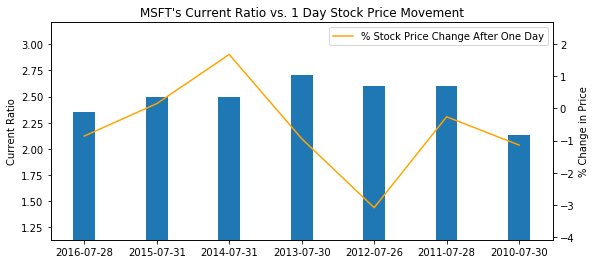

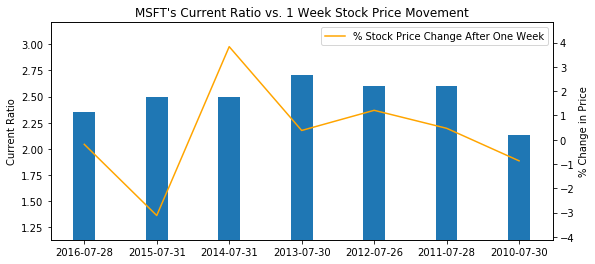

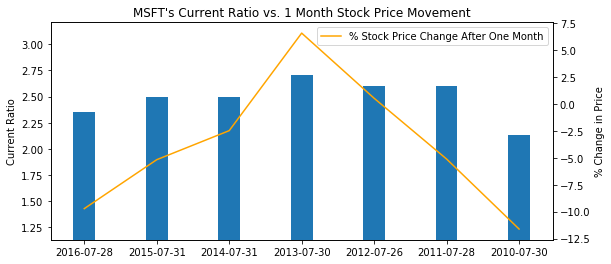

In [154]:
x = []
y = []
z = []
a = []
b = []

for companies_found in range(len(curr_ratio_dict.keys())):
    ticker = list(curr_ratio_dict.keys())[companies_found]

    keys = curr_ratio_dict[ticker].keys()
    curr_ratio_values = curr_ratio_dict[ticker].values()
    day_change_values = per_change_dict[ticker].values()
    week_change_values = week_change_dict[ticker].values()
    month_change_values = month_change_dict[ticker].values()
    
    #plt.bar(keys, values)
    x.append(keys)
    y.append(curr_ratio_values)
    z.append(day_change_values)
    a.append(week_change_values)
    b.append(month_change_values)
    
for i in range(len(x)):
    plot_df = pd.DataFrame ({"% Stock Price Change After One Day":list(z[i])})
    
    plt.figure(figsize=(len(x[i]) + 2, 4))
    plt.bar(x[i],y[i], width = .3)
    plt.ylim(min(y[i])-1, max(y[i])+.5)
    plt.ylabel('Current Ratio')
    
    ax2 = plot_df['% Stock Price Change After One Day'].plot(secondary_y=True, color = 'orange')
    ax2.set_ylim((min(z[i])-1), max(z[i])+1)
    ax2.set_ylabel('% Change in Price')
    
    # Show/save figure as desired.
    plt.title(f"{list(curr_ratio_dict.keys())[i]}'s Current Ratio vs. 1 Day Stock Price Movement")
    plt.legend()
    plt.savefig(f'{list(curr_ratio_dict.keys())[i]}_Curr_Rat_Day.png')
    plt.show()


for i in range(len(x)):
    plot_df = pd.DataFrame ({"% Stock Price Change After One Week":list(a[i])})
    
    plt.figure(figsize=(len(x[i]) + 2, 4))
    plt.bar(x[i],y[i], width = .3)
    plt.ylim(min(y[i])-1, max(y[i])+.5)
    plt.ylabel('Current Ratio')
    
    ax2 = plot_df['% Stock Price Change After One Week'].plot(secondary_y=True, color = 'orange')
    ax2.set_ylim((min(a[i])-1), max(a[i])+1)
    ax2.set_ylabel('% Change in Price')
    
    # Show/save figure as desired.
    plt.title(f"{list(curr_ratio_dict.keys())[i]}'s Current Ratio vs. 1 Week Stock Price Movement")
    plt.legend()
    plt.savefig(f'{list(curr_ratio_dict.keys())[i]}_Curr_Rat_Week.png')
    plt.show()
    
for i in range(len(x)):
    plot_df = pd.DataFrame ({"% Stock Price Change After One Month":list(b[i])})
    
    plt.figure(figsize=(len(x[i]) + 2, 4))
    plt.bar(x[i],y[i], width = .3)
    plt.ylim(min(y[i])-1, max(y[i])+.5)
    plt.ylabel('Current Ratio')
    
    ax2 = plot_df['% Stock Price Change After One Month'].plot(secondary_y=True, color = 'orange')
    ax2.set_ylim((min(b[i])-1), max(b[i])+1)
    ax2.set_ylabel('% Change in Price')
    
    # Show/save figure as desired.
    plt.title(f"{list(curr_ratio_dict.keys())[i]}'s Current Ratio vs. 1 Month Stock Price Movement")
    plt.legend()
    plt.savefig(f'{list(curr_ratio_dict.keys())[i]}_Curr_Rat_Month.png')
    plt.show()

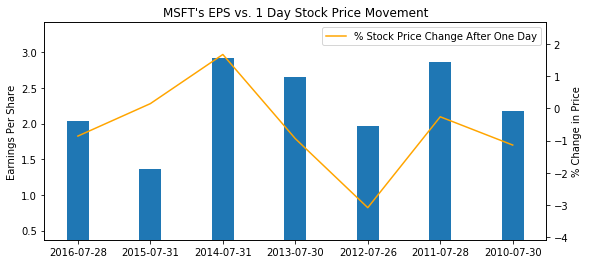

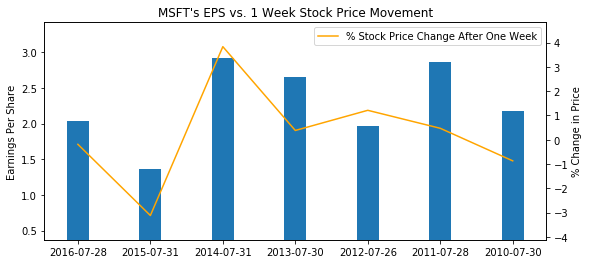

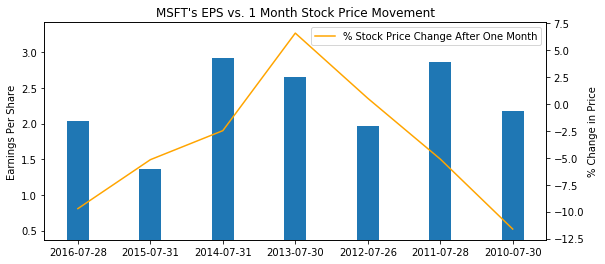

In [153]:
x = []
y = []
z = []
a = []
b = []

for companies_found in range(len(eps_dict.keys())):
    ticker = list(eps_dict.keys())[companies_found]

    keys = eps_dict[ticker].keys()
    eps_values = eps_dict[ticker].values()
    day_change_values = per_change_dict[ticker].values()
    week_change_values = week_change_dict[ticker].values()
    month_change_values = month_change_dict[ticker].values()

    #plt.bar(keys, values)
    x.append(keys)
    y.append(eps_values)
    z.append(day_change_values)
    a.append(week_change_values)
    b.append(month_change_values)


for i in range(len(x)):
    plot_df = pd.DataFrame ({"% Stock Price Change After One Day":list(z[i])})
    
    plt.figure(figsize=(len(x[i]) + 2, 4))
    plt.bar(x[i],y[i], width = .3)
    plt.ylim(min(y[i])-1, max(y[i])+.5)
    plt.ylabel('Earnings Per Share')
    
    ax2 = plot_df['% Stock Price Change After One Day'].plot(secondary_y=True, color = 'orange')
    ax2.set_ylim((min(z[i])-1), max(z[i])+1)
    ax2.set_ylabel('% Change in Price')
    
    # Show/save figure as desired.
    plt.title(f"{list(curr_ratio_dict.keys())[i]}'s EPS vs. 1 Day Stock Price Movement")
    plt.legend()
    plt.savefig(f'{list(curr_ratio_dict.keys())[i]}_EPS_Day.png')
    plt.show()

for i in range(len(x)):
    plot_df = pd.DataFrame ({"% Stock Price Change After One Week":list(a[i])})
    
    plt.figure(figsize=(len(x[i]) + 2, 4))
    plt.bar(x[i],y[i], width = .3)
    plt.ylim(min(y[i])-1, max(y[i])+.5)
    plt.ylabel('Earnings Per Share')
    
    ax2 = plot_df['% Stock Price Change After One Week'].plot(secondary_y=True, color = 'orange')
    ax2.set_ylim((min(a[i])-1), max(a[i])+1)
    ax2.set_ylabel('% Change in Price')
    
    # Show/save figure as desired.
    plt.title(f"{list(curr_ratio_dict.keys())[i]}'s EPS vs. 1 Week Stock Price Movement")
    plt.legend()
    plt.savefig(f'{list(curr_ratio_dict.keys())[i]}_EPS_Week.png')
    plt.show()
    
for i in range(len(x)):
    plot_df = pd.DataFrame ({"% Stock Price Change After One Month":list(b[i])})
    
    plt.figure(figsize=(len(x[i]) + 2, 4))
    plt.bar(x[i],y[i], width = .3)
    plt.ylim(min(y[i])-1, max(y[i])+.5)
    plt.ylabel('Earnings Per Share')
    
    ax2 = plot_df['% Stock Price Change After One Month'].plot(secondary_y=True, color = 'orange')
    ax2.set_ylim((min(b[i])-1), max(b[i])+1)
    ax2.set_ylabel('% Change in Price')
    
    # Show/save figure as desired.
    plt.title(f"{list(curr_ratio_dict.keys())[i]}'s EPS vs. 1 Month Stock Price Movement")
    plt.legend()
    plt.savefig(f'{list(curr_ratio_dict.keys())[i]}_EPS_Month.png')
    plt.show()

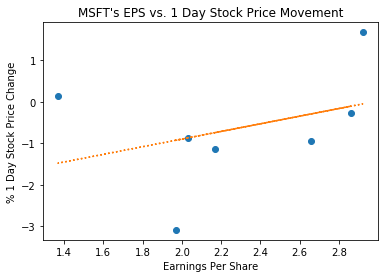

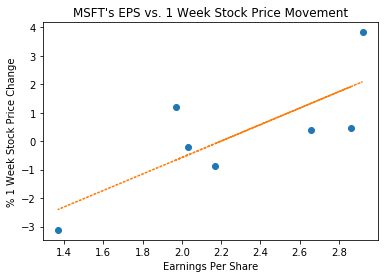

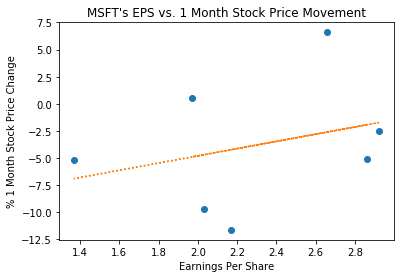

In [155]:
y = []
z = []
a = []
b = []

for companies_found in range(len(eps_dict.keys())):
    ticker = list(eps_dict.keys())[companies_found]

    eps_values = list(eps_dict[ticker].values())
    day_change_values = list(per_change_dict[ticker].values())
    week_change_values = list(week_change_dict[ticker].values())
    month_change_values = list(month_change_dict[ticker].values())
    
    #plt.bar(keys, values)
    y.append(eps_values)
    z.append(day_change_values)
    a.append(week_change_values)
    b.append(month_change_values)
    
for i in range(len(x)):
    fig, ax = plt.subplots()
    ax.plot(y[i], z[i], linewidth=0, marker='o')
    
    (slope, intercept, _, _, _) = linregress(y[i],z[i])
    fit = slope * np.array(y[i]) + intercept
    
    
    ax.plot(y[i], fit, ':')
    
    # Show/save figure as desired.
    plt.title(f"{list(curr_ratio_dict.keys())[i]}'s EPS vs. 1 Day Stock Price Movement")
    plt.ylabel("% 1 Day Stock Price Change")
    plt.xlabel("Earnings Per Share")
    
    plt.savefig(f'{list(curr_ratio_dict.keys())[i]}_EPS_Scat_Day.png')
    plt.show()

    
for i in range(len(x)):
    fig, ax = plt.subplots()
    ax.plot(y[i], a[i], linewidth=0, marker='o')
    
    (slope, intercept, _, _, _) = linregress(y[i],a[i])
    fit = slope * np.array(y[i]) + intercept
    
    
    ax.plot(y[i], fit, ':')
    
    # Show/save figure as desired.
    plt.title(f"{list(curr_ratio_dict.keys())[i]}'s EPS vs. 1 Week Stock Price Movement")
    plt.ylabel("% 1 Week Stock Price Change")
    plt.xlabel("Earnings Per Share")

    plt.savefig(f'{list(curr_ratio_dict.keys())[i]}_EPS_Scat_Week.png')
    plt.show()

    
for i in range(len(x)):
    fig, ax = plt.subplots()
    ax.plot(y[i], b[i], linewidth=0, marker='o')
    
    (slope, intercept, _, _, _) = linregress(y[i],b[i])
    fit = slope * np.array(y[i]) + intercept
    
    
    ax.plot(y[i], fit, ':')
    
    # Show/save figure as desired.
    plt.title(f"{list(curr_ratio_dict.keys())[i]}'s EPS vs. 1 Month Stock Price Movement")
    plt.ylabel("% 1 Month Stock Price Change")
    plt.xlabel("Earnings Per Share")

    plt.savefig(f'{list(curr_ratio_dict.keys())[i]}_EPS_Scat_Month.png')
    plt.show()

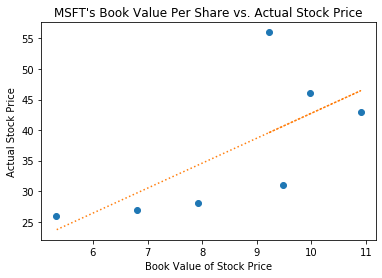

In [158]:
y = []
z = []


for companies_found in range(len(eps_dict.keys())):
    ticker = list(eps_dict.keys())[companies_found]

    bvps_values = list(bvps_dict[ticker].values())
    stock_price = list(stock_price_dict[ticker].values())
    
    #plt.bar(keys, values)
    y.append(bvps_values)
    z.append(stock_price)

for i in range(len(x)):
    fig, ax = plt.subplots()
    ax.plot(y[i], z[i], linewidth=0, marker='o')
    
    (slope, intercept, _, _, _) = linregress(y[i],z[i])
    fit = slope * np.array(y[i]) + intercept
    
    
    ax.plot(y[i], fit, ':')
    
    # Show/save figure as desired.
    plt.title(f"{list(curr_ratio_dict.keys())[i]}'s Book Value Per Share vs. Actual Stock Price")
    plt.ylabel("Actual Stock Price")
    plt.xlabel("Book Value of Stock Price")
    
    plt.savefig(f'{list(curr_ratio_dict.keys())[i]}_BVPS_Scat.png')
    plt.show()
